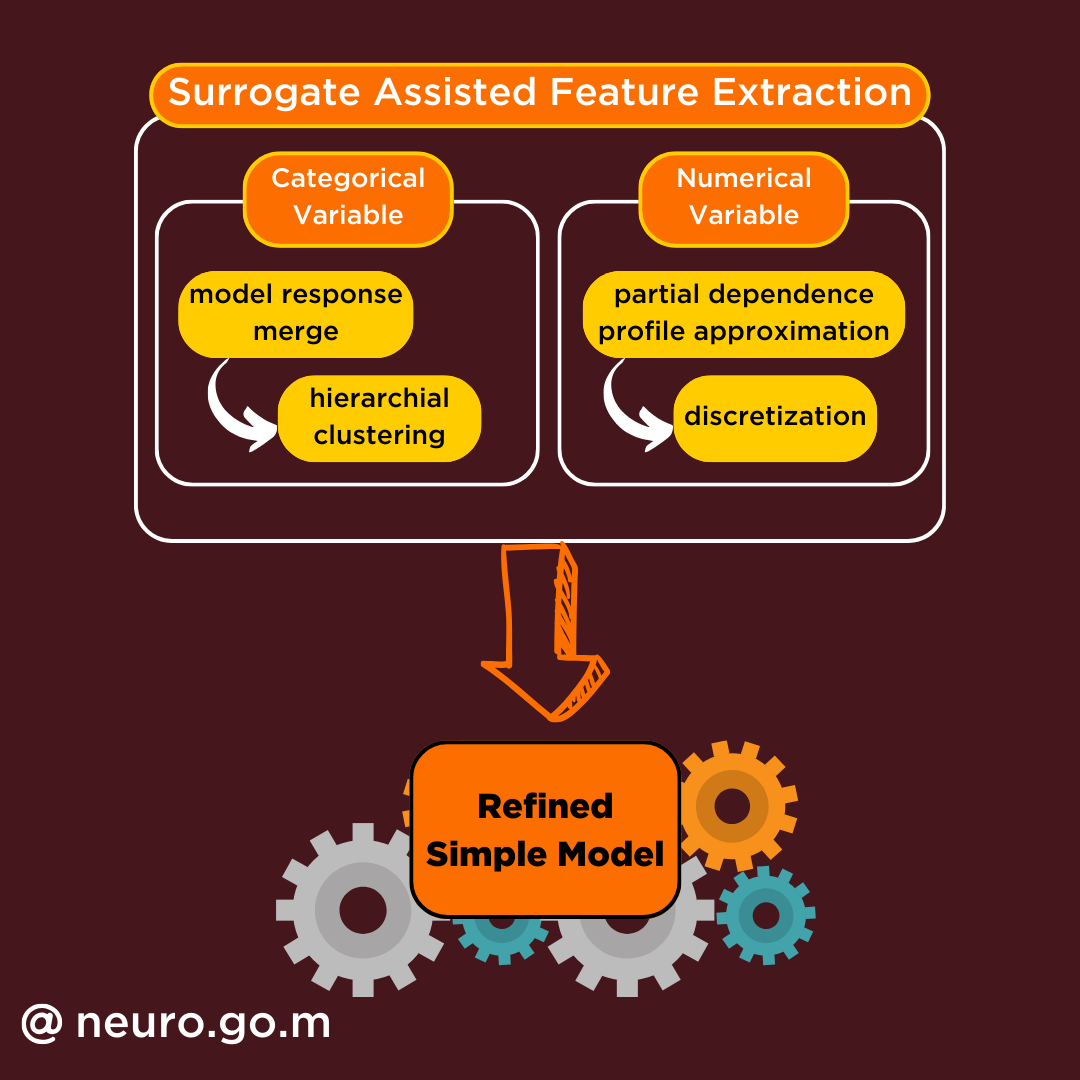

# Import Library

Dependencies : notebook, numpy, pandas, scikit-learn

In [5]:
import sys
sys.path.append('../')  # Add the parent directory to the Python path

import warnings
warnings.filterwarnings("ignore") # Ignore all warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from copy import deepcopy
from Methods.SafeTransformer import SafeTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Load Data

In [6]:
test = pd.read_csv("../data/test.csv")
train = pd.read_csv("../data/train.csv")

In [7]:
train

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500
...,...,...,...,...,...,...,...,...,...,...
37132,37132,3.3438,50.0,4.936508,1.079365,1775.0,3.022222,34.19,-118.36,1.856
37133,37133,3.7308,26.0,5.087533,0.966019,1006.0,4.316901,37.32,-121.86,1.588
37134,37134,4.1716,52.0,4.678862,1.101485,1156.0,1.431734,37.75,-122.44,3.387
37135,37135,2.7143,16.0,5.710074,1.068376,584.0,2.803659,38.40,-120.98,1.592


# Train-Validation Split

In [8]:
X = train.drop(columns=["MedHouseVal"], axis=1)
y = train['MedHouseVal']

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                random_state=2024, 
                                                shuffle=True)

del X, y

# Get Samples

In [9]:
X_train, y_train = X_train[:1000], y_train[:1000]
X_val, y_val = X_val[:1000], y_val[:1000]

# Surrogate Model

A surrogate model is a simplified, interpretable model that approximates the behavior of a more complex, often black-box model. It is typically used as a stand-in for the original model in scenarios where the original model's complexity or lack of interpretability makes it difficult to understand or trust.

In [11]:
surrogate_model = GradientBoostingRegressor(n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    loss='huber')
surrogate_model = surrogate_model.fit(X_train, y_train)

In [12]:
predictions = surrogate_model.predict(X_val)
mean_squared_error(y_val, predictions)

0.45293832434069803

# Main Model

In [13]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [14]:
predictions = linear_model.predict(X_val)
mean_squared_error(y_val, predictions)

0.6536581549378375

# SAFE Transformer

In [15]:
best_score = float('Inf')
best_pen = 0
errors = []
pens = np.linspace(0.05, 0.2, 20)
surrogate_model = surrogate_model.fit(X_train, y_train)
for pen in pens:
    safe_transformer = SafeTransformer(surrogate_model, penalty = pen)

    safe_transformer = safe_transformer.fit(pd.DataFrame(X_train))

    X_train_transformed = safe_transformer.transform(X_train)

    X_val_transformed = safe_transformer.transform(X_val)

    linear_model_transformed = LinearRegression()

    linear_model_transformed = linear_model_transformed.fit(X_train_transformed, y_train)

    surrogate_predictions = linear_model_transformed.predict(X_val_transformed)
    error = mean_squared_error(y_val, surrogate_predictions)
    errors.append(error)
    print([pen,error])
    if error < best_score:
        best_transformer = deepcopy(safe_transformer)
        best_model = deepcopy(linear_model_transformed)
        best_score = error
        best_pen = pen

[0.05, 0.47486666040918407]
[0.05789473684210527, 0.47057929062196774]
[0.06578947368421054, 0.4658737823894135]
[0.0736842105263158, 0.45931770410260014]
[0.08157894736842106, 0.45956810124839986]
[0.08947368421052633, 0.4576678306000026]
[0.09736842105263159, 0.457021267218706]
[0.10526315789473686, 0.45708857588500185]
[0.11315789473684212, 0.45708857588500185]
[0.12105263157894738, 0.4541446625345769]
[0.12894736842105264, 0.4638411871518796]
[0.13684210526315793, 0.4638411871518796]
[0.14473684210526316, 0.4640714070316009]
[0.15263157894736845, 0.4640714070316009]
[0.1605263157894737, 0.4624186829080303]
[0.16842105263157897, 0.4627753812829527]
[0.17631578947368426, 0.4627753812829527]
[0.1842105263157895, 0.4627753812829527]
[0.19210526315789478, 0.4652927526116222]
[0.2, 0.4652927526116222]


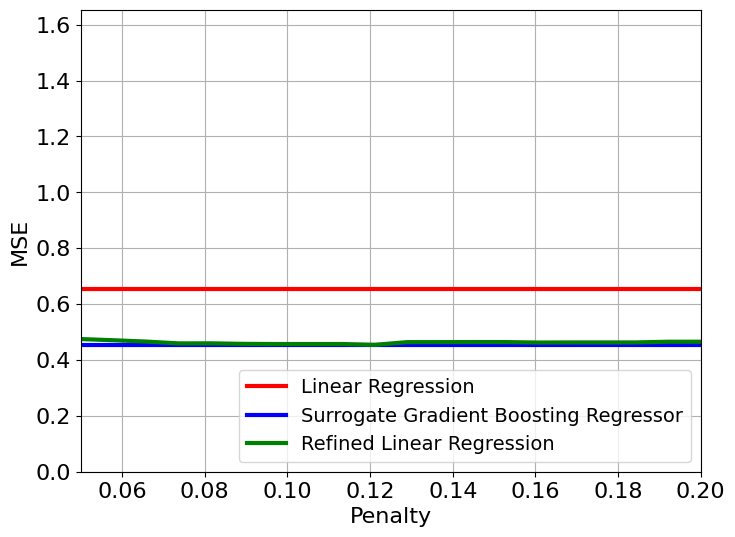

In [24]:

f = plt.figure(figsize=(8, 6))

standard_error = mean_squared_error(y_val, linear_model.predict(X_val))
xgb_error = mean_squared_error(y_val, surrogate_model.predict(X_val))

plt.rcParams.update({'font.size': 14})
plt.xlabel('Penalty', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.grid(True)
plt.axhline(standard_error, color='r', linewidth = 3,label='Linear Regression')
plt.axhline(xgb_error, color='b', linewidth = 3,label='Surrogate Gradient Boosting Regressor')
plt.plot(pens[0:], errors[0:], color = "g", linewidth = 3, label='Refined Linear Regression')

plt.ylim((0, max(max(errors[1:])+1, standard_error+1)))
plt.legend(loc = 'lower right')
plt.xlim([0.05, 0.2])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# f.set_size_inches(12,10, forward = True)

plt.show()